# 02 - Análise exploratória (cs.IR.csv)

## Integrantes da equipe

>   Eduardo Marcelino Junior, 2028409, @eduardo.marcelino, BSI, UTFPR
>
>   Otávio Baziewicz Filho, 1942808, @worgho2, BSI, UTFPR
>
>   Rodrigo William Chavoni, 1996169, @rodrigochavoni, BSI, UTFPR

<!-- -   Para o projeto iremos utilizar 5 subcampos da ciência da computação, que são:
    -   df_AI: Artificial Intelligence
    -   df_DC: Distributed, Parallel, and Cluster Computing
    -   df_IR: Information Retrieval
    -   df_LG: Machine Learning
    -   df_NE: Neural and Evolutionary Computing
-   As bases possuem as mesmas colunas, que são:
    -   ID
    -   Updated
    -   Published
    -   Title
    -   Summary - Resumo do Artigo
    -   Authors
    -   Categories
-   O principal objetivo é analisar a coluna 'Summary', que contém os resumos dos artigos.
-   Primeiramente uma análise individual para cada categoria. Podendo serem feitas:
    -   Nuvem de palavras;
    -   Análise de Tópicos;
    -   (pensar em mais...)
-   Após a primeira análise individual, tentar relacionar as subcategorias.  -->

## Bibliotecas

In [1]:
# Geral
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# NLP
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from textblob import TextBlob
import pyLDAvis.lda_model

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Seed para reprodução de resultados
seed = 1
random.seed(seed)
np.random.seed(seed)

## Carregamento

In [3]:
# Carregamento dos dados 
def load_data(filename):
    return pd.read_csv(f"../output/data/{filename}")

data = load_data("cs.IR.csv").sample(1000)

## Apresentação

In [4]:
# Apresentação dos dados
def show_data_info(data: pd.DataFrame):
    print(f"Shape: {data.shape}")
    print(f"Columns: {data.columns.values}")
    print("Sample:")
    display(data.head())

show_data_info(data)

Shape: (1000, 7)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories
7883,http://arxiv.org/abs/cs/0701143v4,2011-06-20T17:38:19Z,2007-01-23T01:22:59Z,"Dirac Notation, Fock Space and Riemann Metric ...","Using Dirac Notation as a powerful tool, we ...",Xing M. Wang,"cs.IR, math-ph, math.MP, H.3.3"
8230,http://arxiv.org/abs/1301.6770v1,2013-01-28T21:04:45Z,2013-01-28T21:04:45Z,An alternative text representation to TF-IDF a...,"In text mining, information retrieval, and m...","Zhixiang, Xu, Minmin Chen, Kilian Q. Weinber...","cs.IR, cs.LG, stat.ML"
8907,http://arxiv.org/abs/1701.08888v2,2018-12-05T08:50:40Z,2017-01-31T02:13:57Z,Integrating Reviews into Personalized Ranking ...,Item recommendation task predicts a personal...,"Guang-Neng Hu, Xin-Yu Dai","cs.IR, cs.AI, cs.CL"
3059,http://arxiv.org/abs/2304.08138v1,2023-04-17T10:42:30Z,2023-04-17T10:42:30Z,Typos-aware Bottlenecked Pre-Training for Robu...,Current dense retrievers (DRs) are limited i...,"Shengyao Zhuang, Linjun Shou, Jian Pei, Ming G...",cs.IR
6708,http://arxiv.org/abs/2205.12042v1,2022-05-24T12:51:52Z,2022-05-24T12:51:52Z,HCFRec: Hash Collaborative Filtering via Norma...,The ever-increasing data scale of user-item ...,"Fan Wang, Weiming Liu, Chaochao Chen, Mengying...","cs.IR, cs.AI"


## Normalização dos dados

In [5]:
# Normalização dos dados (remoção de stopwords, pontuação, etc)
def normalize_text(text: str):
    stopword_list = nltk.corpus.stopwords.words('english')
    return  " ".join([word for word in word_tokenize(text.lower()) if word not in stopword_list and word.isalpha()])


# Geração de coluna normalizada com base em outra coluna
def generate_normalized_column(data: pd.DataFrame, from_column: str):
    new_column_name = f"{from_column}_Normalized"
    print(f"New column name: {new_column_name}")
    data[new_column_name] = data.apply(lambda linha: normalize_text(str(linha[from_column])), axis = 1)
    return new_column_name


normalized_summary_column_name = generate_normalized_column(data=data, from_column="Summary")
show_data_info(data)

New column name: Summary_Normalized


Shape: (1000, 8)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories'
 'Summary_Normalized']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories,Summary_Normalized
7883,http://arxiv.org/abs/cs/0701143v4,2011-06-20T17:38:19Z,2007-01-23T01:22:59Z,"Dirac Notation, Fock Space and Riemann Metric ...","Using Dirac Notation as a powerful tool, we ...",Xing M. Wang,"cs.IR, math-ph, math.MP, H.3.3",using dirac notation powerful tool investigate...
8230,http://arxiv.org/abs/1301.6770v1,2013-01-28T21:04:45Z,2013-01-28T21:04:45Z,An alternative text representation to TF-IDF a...,"In text mining, information retrieval, and m...","Zhixiang, Xu, Minmin Chen, Kilian Q. Weinber...","cs.IR, cs.LG, stat.ML",text mining information retrieval machine lear...
8907,http://arxiv.org/abs/1701.08888v2,2018-12-05T08:50:40Z,2017-01-31T02:13:57Z,Integrating Reviews into Personalized Ranking ...,Item recommendation task predicts a personal...,"Guang-Neng Hu, Xin-Yu Dai","cs.IR, cs.AI, cs.CL",item recommendation task predicts personalized...
3059,http://arxiv.org/abs/2304.08138v1,2023-04-17T10:42:30Z,2023-04-17T10:42:30Z,Typos-aware Bottlenecked Pre-Training for Robu...,Current dense retrievers (DRs) are limited i...,"Shengyao Zhuang, Linjun Shou, Jian Pei, Ming G...",cs.IR,current dense retrievers drs limited ability e...
6708,http://arxiv.org/abs/2205.12042v1,2022-05-24T12:51:52Z,2022-05-24T12:51:52Z,HCFRec: Hash Collaborative Filtering via Norma...,The ever-increasing data scale of user-item ...,"Fan Wang, Weiming Liu, Chaochao Chen, Mengying...","cs.IR, cs.AI",data scale interactions makes challenging effe...


## Histograma e Nuvem de Palavras

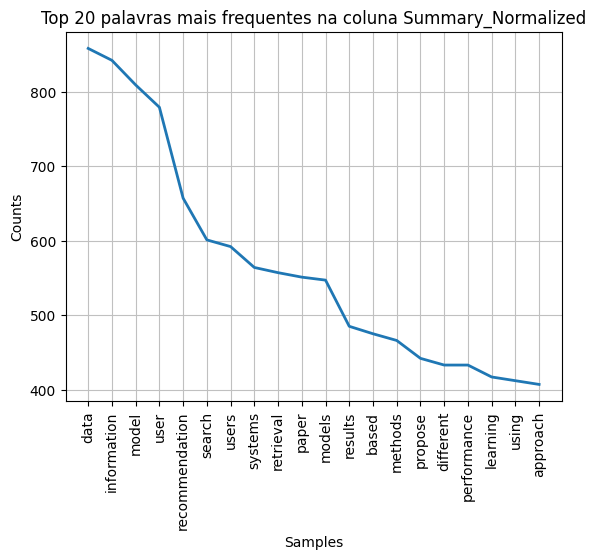

C:\Users\rodri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


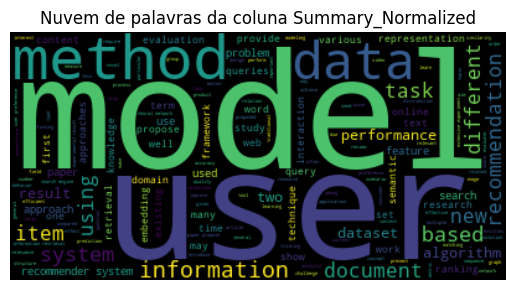

In [6]:
# Geração do histograma de frequência de palavras
def plot_word_frequency_histogram_and_wordcloud(data: pd.DataFrame, column: str, top: int):
    column_data = " ".join(data[column])

    # Histograma
    fdist = FreqDist(column_data.split(" "))
    fdist.plot(top, title=f"Top {top} palavras mais frequentes na coluna {column}")

    # Wordcloud
    wordcloud = WordCloud().generate(column_data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Nuvem de palavras da coluna {column}")
    plt.axis("off")
    plt.show()

plot_word_frequency_histogram_and_wordcloud(data=data, column=normalized_summary_column_name, top=20)

## Polaridade e Subjetividade

In [7]:
# Adição de coluna de polaridade e subjetividade com base em outra coluna
def generate_polarity_and_subjectivity_columns(data: pd.DataFrame, from_column: str):
    new_polarity_column_name = f"{from_column}_Polarity"
    data[new_polarity_column_name] = data[from_column].apply(lambda text: TextBlob(text).sentiment.polarity)

    new_subjectivity_column_name = f"{from_column}_Subjectivity"
    data[new_subjectivity_column_name] = data[from_column].apply(lambda text: TextBlob(text).sentiment.subjectivity)

    return new_polarity_column_name, new_subjectivity_column_name

normalized_summary_polarity_column_name, normalized_summary_subjectivity_column_name = generate_polarity_and_subjectivity_columns(data=data, from_column=normalized_summary_column_name)
show_data_info(data)

Shape: (1000, 10)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories'
 'Summary_Normalized' 'Summary_Normalized_Polarity'
 'Summary_Normalized_Subjectivity']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories,Summary_Normalized,Summary_Normalized_Polarity,Summary_Normalized_Subjectivity
7883,http://arxiv.org/abs/cs/0701143v4,2011-06-20T17:38:19Z,2007-01-23T01:22:59Z,"Dirac Notation, Fock Space and Riemann Metric ...","Using Dirac Notation as a powerful tool, we ...",Xing M. Wang,"cs.IR, math-ph, math.MP, H.3.3",using dirac notation powerful tool investigate...,0.116667,0.465278
8230,http://arxiv.org/abs/1301.6770v1,2013-01-28T21:04:45Z,2013-01-28T21:04:45Z,An alternative text representation to TF-IDF a...,"In text mining, information retrieval, and m...","Zhixiang, Xu, Minmin Chen, Kilian Q. Weinber...","cs.IR, cs.LG, stat.ML",text mining information retrieval machine lear...,0.004541,0.443929
8907,http://arxiv.org/abs/1701.08888v2,2018-12-05T08:50:40Z,2017-01-31T02:13:57Z,Integrating Reviews into Personalized Ranking ...,Item recommendation task predicts a personal...,"Guang-Neng Hu, Xin-Yu Dai","cs.IR, cs.AI, cs.CL",item recommendation task predicts personalized...,0.035000,0.500714
3059,http://arxiv.org/abs/2304.08138v1,2023-04-17T10:42:30Z,2023-04-17T10:42:30Z,Typos-aware Bottlenecked Pre-Training for Robu...,Current dense retrievers (DRs) are limited i...,"Shengyao Zhuang, Linjun Shou, Jian Pei, Ming G...",cs.IR,current dense retrievers drs limited ability e...,0.110119,0.471949
6708,http://arxiv.org/abs/2205.12042v1,2022-05-24T12:51:52Z,2022-05-24T12:51:52Z,HCFRec: Hash Collaborative Filtering via Norma...,The ever-increasing data scale of user-item ...,"Fan Wang, Weiming Liu, Chaochao Chen, Mengying...","cs.IR, cs.AI",data scale interactions makes challenging effe...,0.237500,0.672222


## Lemmatization

In [8]:
# Aplicação de lematização em coluna, retornando uma lista de palavras em sua forma raiz
def apply_lemmatization_to_column(data: pd.DataFrame, column: str, allowed_postags: list[str] = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load("en_core_web_sm")

    column_words = data[column].map(lambda text: TextBlob(text).words)

    lemma_column_words = []
    for words in column_words:
        doc = nlp(" ".join(words))
        lemma_column_words.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))

    return lemma_column_words

summary_lemma = apply_lemmatization_to_column(data=data, column=normalized_summary_column_name)

## Vetorização

In [9]:
summary_vectorizer = CountVectorizer(
    analyzer='word',       
    min_df=10,                        # minimum required occurences of a word 
    stop_words='english',             # remove stop words
    lowercase=True,                   # convert all words to lowercase
    token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
    # max_features=50000,             # max number of unique words
)

vectorized_summary_lemma = summary_vectorizer.fit_transform(summary_lemma)

## Sparsity

In [10]:
def get_vectorized_lemma_sparcity(vectorized_lemma: np.ndarray):
    dense_vectorized_lemma = vectorized_lemma.todense()
    return ((dense_vectorized_lemma > 0).sum()/dense_vectorized_lemma.size)*100

print(f"Sparcity: {get_vectorized_lemma_sparcity(vectorized_lemma=vectorized_summary_lemma)}%")

Sparcity: 4.495372750642673%


## LDA Grid Search

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -104855.3403383769
Model Perplexity:  591.2725570056501


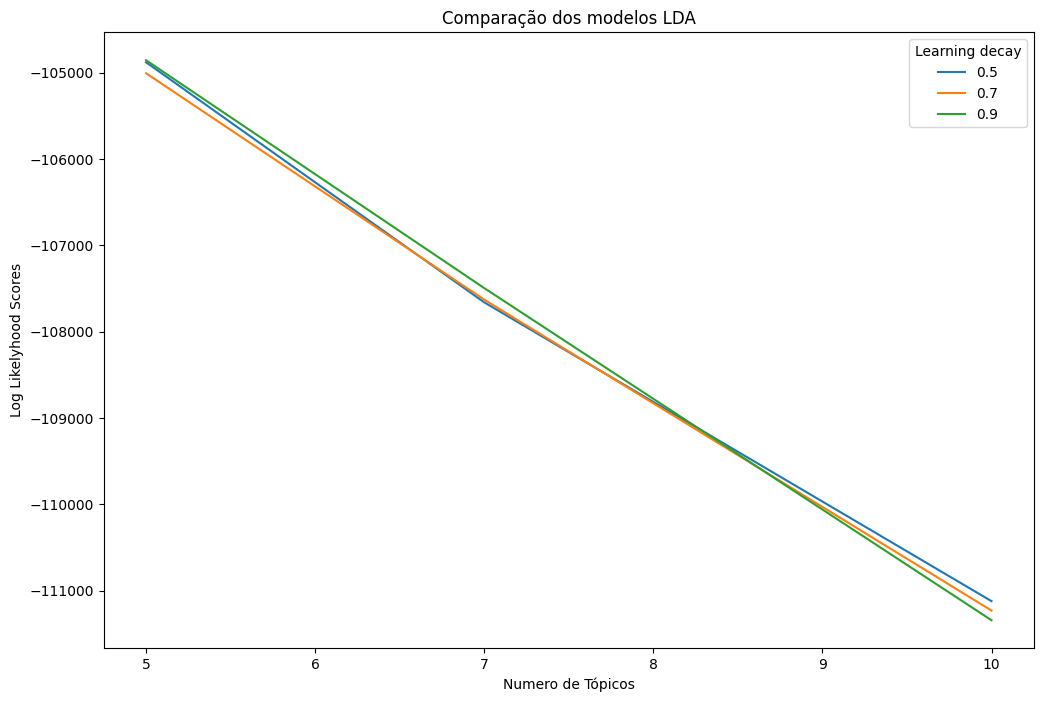

In [11]:
# Geração de modelo LDA com base em parâmetros otimizados pelo GridSearch
lda = LatentDirichletAllocation()
search_params = {
    'n_components': [5, 7, 10],
    'learning_decay': [.5, .7, .9]
}
model = GridSearchCV(lda, param_grid=search_params)
model.fit(vectorized_summary_lemma)

# Parâmetros do melhor modelo
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(vectorized_summary_lemma))


# Visualização dos parâmetros otimizados pelo GridSearch
plt.figure(figsize=(12, 8))
for i in range(len(search_params['learning_decay'])):
    plt.plot(
        search_params['n_components'],
        [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==search_params['learning_decay'][i]],
        label=str(search_params['learning_decay'][i])
    )
plt.title("Comparação dos modelos LDA")
plt.xlabel("Numero de Tópicos")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


## Análise de Tópicos

In [12]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(vectorized_summary_lemma)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data[normalized_summary_column_name]))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4
Doc0,0.11,0.10,0.43,0.36,0.00
Doc1,0.18,0.60,0.21,0.00,0.00
Doc2,0.85,0.00,0.07,0.00,0.07
Doc3,0.00,0.00,0.99,0.00,0.00
Doc4,0.74,0.25,0.00,0.00,0.00
...,...,...,...,...,...
Doc995,0.12,0.00,0.00,0.87,0.00
Doc996,0.15,0.00,0.00,0.84,0.00
Doc997,0.00,0.18,0.00,0.10,0.71
Doc998,0.00,0.00,0.00,0.98,0.00


In [13]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.110000,0.100000,0.430000,0.360000,0.000000,2
Doc1,0.180000,0.600000,0.210000,0.000000,0.000000,1
Doc2,0.850000,0.000000,0.070000,0.000000,0.070000,0
Doc3,0.000000,0.000000,0.990000,0.000000,0.000000,2
Doc4,0.740000,0.250000,0.000000,0.000000,0.000000,0
Doc5,0.000000,0.000000,0.000000,0.050000,0.930000,4
Doc6,0.630000,0.010000,0.080000,0.280000,0.000000,0
Doc7,0.220000,0.000000,0.480000,0.300000,0.000000,2
Doc8,0.010000,0.250000,0.010000,0.740000,0.010000,3
Doc9,0.000000,0.000000,0.000000,0.610000,0.380000,3


In [14]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,280
1,0,228
2,2,214
3,4,170
4,1,108


In [15]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = summary_vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ability,able,abstract,academic,accelerate,access,accessible,accord,accordingly,account,...,weighting,wide,widely,wikipedia,word,work,world,write,year,yield
Topic0,26.351297,13.991209,0.201327,0.200879,2.473944,0.200887,0.200041,17.104738,9.582547,10.982953,...,10.300575,7.656949,38.106002,0.200419,5.654156,54.511475,4.195488,0.200103,15.976069,8.670376
Topic1,3.887661,9.279391,16.605444,0.204291,4.138648,8.430707,0.202814,6.284765,0.201220,0.204131,...,0.246541,3.335233,0.207232,0.202072,130.007634,35.353687,7.945366,0.207949,8.597001,0.212599
Topic2,21.869605,12.129203,0.204339,0.202677,0.204613,0.456670,0.200121,7.051232,0.200781,0.286675,...,3.986943,8.389518,1.397496,1.385421,14.368152,64.685815,7.588177,3.882711,0.246038,13.739486
Topic3,13.387277,12.472578,8.786907,27.659481,0.204056,40.447534,11.194787,28.247535,0.211611,27.367199,...,2.253302,9.816016,8.375199,25.010202,55.586690,86.964531,23.093329,12.508060,11.978401,2.175556
Topic4,1.504161,8.127620,0.201983,3.732672,3.978739,11.464202,0.202237,5.311730,2.803840,22.159042,...,0.212639,9.802285,19.914071,0.201886,0.383368,87.484491,8.177640,0.201178,32.202492,0.201983


In [16]:
# Show top n keywords for each topic
def show_topics(vectorizer=summary_vectorizer, lda_model=lda_output, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=summary_vectorizer, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,user,model,recommendation,item,propose,method,learn,graph,information,dataset,representation,interaction,problem,datum,network
Topic 1,model,datum,topic,document,method,use,word,text,approach,propose,set,classification,label,training,information
Topic 2,model,retrieval,query,rank,document,use,task,method,result,search,propose,language,performance,answer,question
Topic 3,search,use,information,web,datum,paper,result,user,research,engine,base,approach,query,different,semantic
Topic 4,user,recommendation,recommender,news,model,social,propose,evaluation,online,provide,datum,study,paper,use,bias


### LDAVis

In [17]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(best_lda_model, vectorized_summary_lemma, summary_vectorizer, mds='tsne')


pyLDAvis.display(panel)

In [18]:
pyLDAvis.save_html(panel, 'C:\\Users\\rodri\\Documents\\recuperacao-de-informacao\\02 - Analise exploratoria\\arxiv\\ldavis_html\\lda_ir.html')